<a href="https://colab.research.google.com/github/ck1972/University-GeoAI/blob/main/Lab_4_TorchGeo_DaresSalaam_Satellite_imagery_cropping512x512_data_augmentation_model_XAI_Model4_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning for Mapping Building Footprints: Using Grad-CAM for Enhanced Explainability**

## Dataset
In this tutorial, we are going to extract building footprint using satellite imagery and the DeepLabV3-ResNet50 model.

We use the Dar es Salaam dataset from OpenEarthMap, which is a benchmark dataset for global high-resolution land cover mapping. OpenEarthMap consists of 5000 aerial and satellite images with manually annotated 8-class land cover labels and 2.2 million segments at a 0.25-0.5m ground sampling distance, covering 97 regions from 44 countries across 6 continents. Land cover mapping models trained on OpenEarthMap generalize worldwide and can be used as off-the-shelf models in a variety of applications.

The Dar es Salaam dataset consist of 91 training images and masks (1024x1024). In this script, we use cropped images and masks to 512x512 and do data augmentation.


## **Organization of the Tutorial**
The video tutorial is organized as follows:
1. Environment setup and library installation
2. Preprocessing the datasets
3. Deep learning using a DeepLabV3-ResNet50 model
4. Gradient-weighted class activation mapping (Grad-CAM)

# Environment and Libraries
## Install and import libraries
First, we will install (if not available) and import the necesssary libraries.

In [ ]:
# Install TorchGeo
!pip install torchgeo
!pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.7/454.7 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.0/849.0 kB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 39.8 MB/s eta 0:00

In [ ]:
# Import the necessary libraries
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet50

from skimage import measure  # for connected component labeling

# For reproducibility
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

## Set up environment
Mount your Google drive to access to your dataset.

In [ ]:
# Mount the Google Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


 Next, set up your working directory.

In [ ]:
# Set the working directory
import os
os.chdir(r'/content/drive/MyDrive/Unet_models_2024/Dar_es_Salaam_Segmentation/Training/Training512x512')

## Data preprocessing
Prepare your datasets. Ensure that your datasets are sorted. That is, the image matches the mask.

In [ ]:
# Sort the training and test datasets
train_x = sorted(glob.glob('train/*_image.tif'))
train_y = sorted(glob.glob('train/*_label.tif'))
test_x = sorted(glob.glob('test/*_image.tif'))
test_y = sorted(glob.glob('test/*_label.tif'))

print(len(train_x), len(test_x))

71 20


Convert the training images and masks to numpy arrays.

In [ ]:
# Convert training image to numpy array
train_xx = np.zeros((71, 512, 512, 3))
train_yy = np.zeros((71, 512, 512, 1))
for i, (img, mask) in enumerate(zip(train_x, train_y)):

  img = Image.open(img)
  np_img = np.array(img)
  train_xx[i] = np_img

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(512, 512, 1)
  train_yy[i] = np_mask

Convert the test images and masks to numpy arrays.

In [ ]:
# Convert test images and masks to numpy array
test_xx = np.zeros((20, 512, 512, 3))
test_yy = np.zeros((20, 512, 512, 1))
for i, (img_path, mask_path) in enumerate(zip(test_x, test_y)):
    img = Image.open(img_path)
    np_img = np.array(img)
    test_xx[i] = np_img

    mask = Image.open(mask_path)
    np_mask = np.array(mask).reshape(512, 512, 1)  # Ensure mask is in the correct shape
    test_yy[i] = np_mask

Display a selected image and corresponding mask.

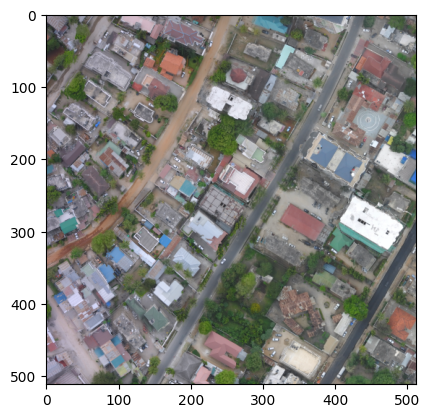

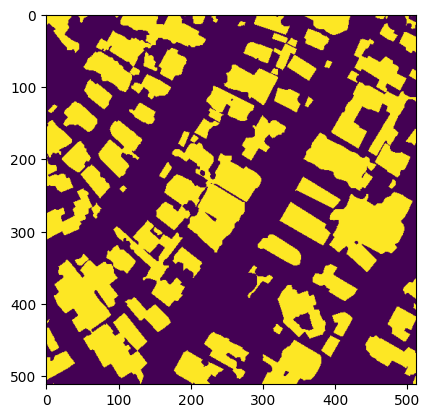

In [ ]:
# Plot a sample input RGB image and building mask
plt.imshow(train_xx[40, :, :, :].astype('uint8'))
plt.show()
plt.imshow(train_yy[40, :, :, 0].astype('uint8'))
plt.show()

# Save to numpy format
Check the shape of the image and mask.

In [ ]:
# Check the shape
print(train_xx.shape)
print(train_yy.shape)
print(test_xx.shape)
print(test_yy.shape)

(71, 512, 512, 3)
(71, 512, 512, 1)
(20, 512, 512, 3)
(20, 512, 512, 1)


### Custom dataset
The BuildingDataset class loads images and masks from NumPy arrays (which you prepared earlier) and applies any necessary transforms. We convert masks to a LongTensor since the loss function (CrossEntropyLoss) expects integer class labels.

In [ ]:
# ========================
# 1. Create a Custom Dataset
# ========================

class BuildingDataset(Dataset):
    def __init__(self, images, masks, transform_img=None, transform_mask=None):
        """
        Args:
            images (np.array): Array of images with shape (N, H, W, 3).
            masks (np.array): Array of masks with shape (N, H, W, 1) where values are 0 or 1.
            transform_img (callable, optional): Transform for images.
            transform_mask (callable, optional): Transform for masks.
        """
        self.images = images
        self.masks = masks
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        # Convert image and mask to PIL images
        img = Image.fromarray(self.images[idx].astype('uint8'))
        mask = Image.fromarray(self.masks[idx, :, :, 0].astype('uint8'))  # squeeze last dim

        if self.transform_img:
            img = self.transform_img(img)
        else:
            # Default: convert to tensor and normalize to [0,1]
            img = T.ToTensor()(img)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        else:
            # For the mask, we want a LongTensor (with class indices)
            mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

### Data preparation
We create training and test datasets and wrap them in DataLoaders. (Feel free to integrate your augmentation pipelines here if you wish to perform on-the-fly augmentation in PyTorch.)

In [ ]:
# ========================
# 2. Prepare Data
# ========================

# Assuming you have already loaded your data into train_xx, train_yy, test_xx, test_yy
# (from your provided code snippet)

# Example transforms for images (you may add normalization if required)
transform_img = T.Compose([
    T.ToTensor(),  # converts [0,255] to [0,1] and HWC -> CHW
    # e.g., T.Normalize(mean=[0.485, 0.456, 0.406],
    #                   std=[0.229, 0.224, 0.225])
])
# For masks, we simply convert to tensor (keeping integer labels)
def transform_mask(mask):
    return torch.from_numpy(np.array(mask)).long()

# Create datasets
train_dataset = BuildingDataset(train_xx, train_yy, transform_img=transform_img, transform_mask=transform_mask)
test_dataset = BuildingDataset(test_xx, test_yy, transform_img=transform_img, transform_mask=transform_mask)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

### Model setup
We load a pretrained DeepLabV3-ResNet50 model from torchvision and replace its final classifier layer to output two classes.

In [ ]:
# ========================
# 3. Setup the DeepLabV3 Model
# ========================

# We have 2 classes: background (0) and building (1)
num_classes = 2

# Load a pretrained model
model = deeplabv3_resnet50(pretrained=True)

# Replace the classifier head with one that has the correct number of output classes.
model.classifier[-1] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))

# Move model to device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 159MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### Training
The training loop runs for a few epochs (set here to 5 as an example). We use the cross-entropy loss and Adam optimizer.

In [ ]:
# ========================
# 4. Training Setup
# ========================

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()  # expects logits of shape (N, C, H, W) and target of shape (N, H, W)

num_epochs = 20  # increase as needed

# Training loop
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for imgs, masks in train_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)['out']  # DeepLabV3 returns a dict with key 'out'
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/20, Loss: 0.5979
Epoch 2/20, Loss: 0.4889
Epoch 3/20, Loss: 0.3983
Epoch 4/20, Loss: 0.3318
Epoch 5/20, Loss: 0.3176
Epoch 6/20, Loss: 0.2848
Epoch 7/20, Loss: 0.2557
Epoch 8/20, Loss: 0.2480
Epoch 9/20, Loss: 0.2334
Epoch 10/20, Loss: 0.2200
Epoch 11/20, Loss: 0.2046
Epoch 12/20, Loss: 0.2043
Epoch 13/20, Loss: 0.1943
Epoch 14/20, Loss: 0.2110
Epoch 15/20, Loss: 0.1902
Epoch 16/20, Loss: 0.1828
Epoch 17/20, Loss: 0.1721
Epoch 18/20, Loss: 0.1718
Epoch 19/20, Loss: 0.1621
Epoch 20/20, Loss: 0.1551


### Evaluation
We evaluate on test data by computing pixel accuracy and Intersection over Union (IoU) for the building class.

In [ ]:
model.eval()
# We will compute a simple pixel accuracy and IoU for the building class
def compute_metrics(pred, target, num_classes=2):
    """
    Computes pixel accuracy and IoU for the building class (class index 1).
    """
    pred = pred.flatten()
    target = target.flatten()

    pixel_acc = (pred == target).sum() / len(target)

    # Intersection over Union for building class (class 1)
    intersection = ((pred == 1) & (target == 1)).sum()
    union = ((pred == 1) | (target == 1)).sum()
    iou = intersection / union if union != 0 else 0.0

    return pixel_acc, iou

all_acc, all_iou = [], []
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = model(imgs)['out']
        # Get predicted classes (argmax over channels)
        preds = torch.argmax(outputs, dim=1)
        acc, iou = compute_metrics(preds.cpu().numpy(), masks.cpu().numpy())
        all_acc.append(acc)
        all_iou.append(iou)

print("Test Pixel Accuracy: {:.4f}".format(np.mean(all_acc)))
print("Test IoU (building): {:.4f}".format(np.mean(all_iou)))

Test Pixel Accuracy: 0.9139
Test IoU (building): 0.6620


### Visualization & instance extraction
After predicting on a test image, we display the original image, the ground truth mask, the semantic segmentation, and finally an instance segmentation result generated by applying connected component labeling (via skimage.measure.label) on the building class regions.



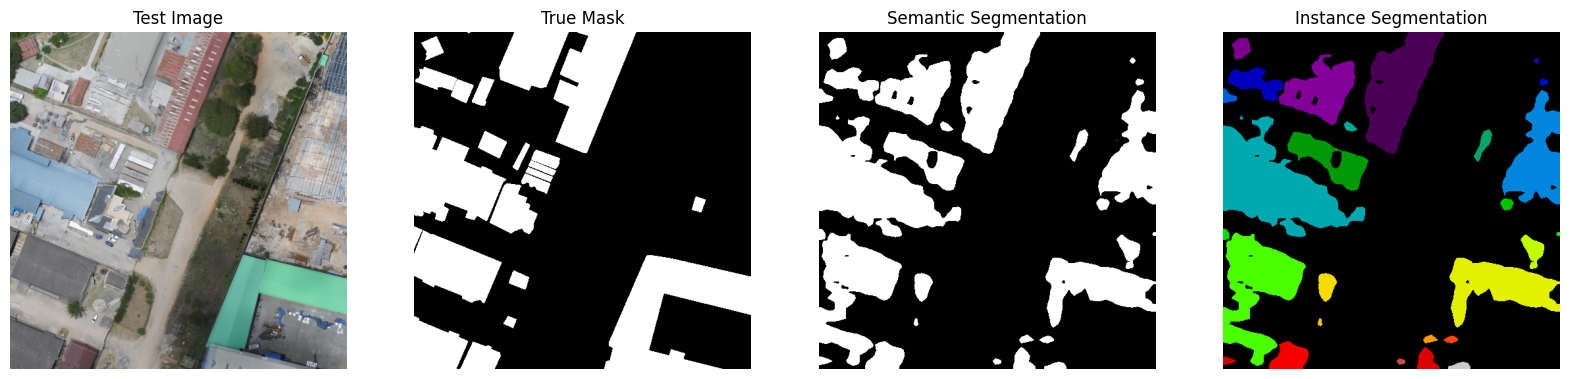

In [ ]:
# ========================
# 6. Visualize Segmentation and Perform Instance Extraction
# ========================

# Pick a sample test image and get prediction
sample_img, sample_mask = test_dataset[0]
model.eval()
with torch.no_grad():
    output = model(sample_img.unsqueeze(0).to(device))['out']
pred_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()

# Optionally, perform connected component analysis to split building footprints into instances.
# Here, we label connected regions (for the building class, label==1).
if np.any(pred_mask == 1):
    labeled_instances = measure.label(pred_mask == 1, connectivity=2)
else:
    labeled_instances = np.zeros_like(pred_mask)

# Plot the original image, true mask, semantic segmentation, and instance segmentation results.
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(sample_img.permute(1,2,0).cpu().numpy())
axs[0].set_title("Test Image")
axs[0].axis('off')

axs[1].imshow(sample_mask.cpu().numpy(), cmap='gray')
axs[1].set_title("True Mask")
axs[1].axis('off')

axs[2].imshow(pred_mask, cmap='gray')
axs[2].set_title("Semantic Segmentation")
axs[2].axis('off')

axs[3].imshow(labeled_instances, cmap='nipy_spectral')
axs[3].set_title("Instance Segmentation")
axs[3].axis('off')

plt.show()

## **Explainable Deep Learning using Grad-CAM**
### Grad-CAM with layer attribution and activation maps
In this section, we implement Grad-CAM to visually interpret which parts of an image influenced the model’s decision during the segmentation task. The GradCAM class takes a model and a target layer on which you want to inspect activations. It registers forward and backward hooks to capture both the activations and the gradients during the model's inference process. In the generate_cam method, after performing a forward pass, a backward pass is triggered by computing a loss defined as the sum of the logits for the target class. The gradients are then globally averaged over the spatial dimensions, and a weighted sum of the activations is computed to generate the final heatmap. In our example, we select model.backbone.layer4[-1] as the target layer, although you can experiment with other layers depending on the insights you seek.

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Define GradCAM class
class GradCAM:
    def __init__(self, model, target_layer):
        """
        Args:
            model (torch.nn.Module): The segmentation model.
            target_layer (torch.nn.Module): The target layer for which gradients and activations will be captured.
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.forward_handle = self.target_layer.register_forward_hook(self.forward_hook)
        self.backward_handle = self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        # Save the activations
        self.activations = output.detach()

    def backward_hook(self, module, grad_in, grad_out):
        # Save the gradients (grad_out is a tuple; we take the first element)
        self.gradients = grad_out[0].detach()

    def generate_cam(self, input_image, target_class):
        """
        Generates the GradCAM heatmap for the specified target class.

        Args:
            input_image (torch.Tensor): Input image tensor of shape (1, C, H, W).
            target_class (int): The class index for which to compute the CAM.

        Returns:
            cam (np.array): The CAM heatmap as a numpy array (H, W).
        """
        # Forward pass
        output = self.model(input_image)['out']  # shape: (1, num_classes, H_out, W_out)
        # Compute a scalar loss for the target class.
        # For segmentation, we sum over all spatial locations.
        loss = output[:, target_class, :, :].sum()

        # Backward pass
        self.model.zero_grad()
        loss.backward(retain_graph=True)

        # Global average pooling on gradients (over the spatial dimensions)
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)  # shape: (1, channels, 1, 1)

        # Compute the weighted combination of forward activation maps
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)

        # Upsample the CAM to the input image size
        cam = F.interpolate(cam, size=input_image.shape[2:], mode='bilinear', align_corners=False)

        # Normalize the CAM
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.squeeze().cpu().numpy()

    def remove_hooks(self):
        self.forward_handle.remove()
        self.backward_handle.remove()

### Grad-CAM to extract activations and gradients
We first choose a target layer from the model, specifically the last convolutional block of the backbone (i.e., model.backbone.layer4[-1]), which is used by GradCAM to extract activations and gradients for visualizing important regions. We then instantiate the GradCAM class with the model and the chosen target layer. Next, a sample image is extracted from the test dataset and a batch dimension is added to it before sending it to the appropriate device (CPU or GPU). The target class for the GradCAM visualization is specified as 1 (indicating buildings). Using the generate_cam method, we compute the CAM heatmap for this target class. Once the heatmap is generated, we remove the hooks registered earlier to avoid potential side effects. For visualization purposes, the input image is transformed from a tensor with shape (C, H, W) to a NumPy array with shape (H, W, C) and normalized. Finally, the image is plotted with the CAM heatmap overlayed using a 'jet' colormap, providing a clear visualization of the regions that influenced the model's prediction for the building class.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


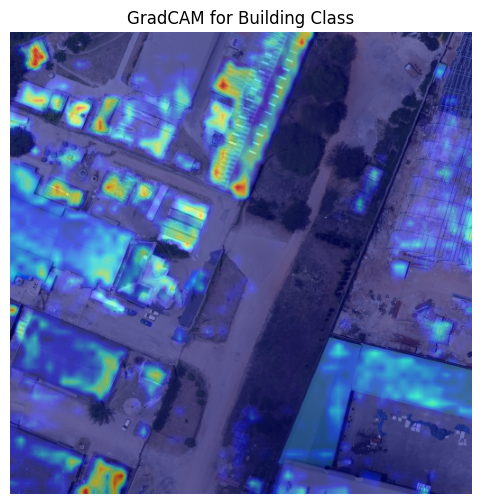

In [ ]:
# ========================
# Example Usage of GradCAM
# ========================

# Assume `model` is your DeepLabV3-ResNet50 model already trained and on `device`
# and that you have a sample image from your test dataset.
# We'll choose the last layer of the backbone as our target layer.
target_layer = model.backbone.layer4[-1]
gradcam = GradCAM(model, target_layer)

# Get a sample test image (here using the first image from test_dataset)
# sample_img is a tensor of shape (C, H, W). We need to add a batch dimension.
sample_img, _ = test_dataset[0]
input_img = sample_img.unsqueeze(0).to(device)

# Specify target class (buildings are labeled as 1)
target_class = 1

# Generate the CAM heatmap
cam_heatmap = gradcam.generate_cam(input_img, target_class)

# Remove hooks when done
gradcam.remove_hooks()

# Convert input image for visualization (C, H, W) -> (H, W, C) and bring to CPU
img_np = sample_img.permute(1, 2, 0).cpu().numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # normalize if needed

# Plot the image and overlay the CAM heatmap
plt.figure(figsize=(8, 6))
plt.imshow(img_np)
plt.imshow(cam_heatmap, cmap='jet', alpha=0.5)  # adjust alpha for transparency
plt.title("GradCAM for Building Class")
plt.axis('off')
plt.show()

Data Source: https://open-earth-map.org/

Note:
The source of the Dar es salaam(Tanzania) dataset is Open Cities AI and the data provider is the Global Facility for Disaster Reduction and Recovery. The dataset is available under the CCBY4.0 license.

In [ ]:
!jupyter nbconvert --to html /content/sample_data/TorchGeo_DaresSalaam_Satellite_imagery_cropping512x512_data_augmentation_model_XAI_Model4_Final.ipynb